In [1]:
import scipy as sp
import scipy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm
from tabulate import tabulate
from scipy.interpolate import RegularGridInterpolator

from sys import getsizeof
import sys

## Direct Processing

In [85]:
def predict_mem(NN,slices):
    return 64*(NN/1024)**3/slices

def det_slices(NN, mem=4):
    NNs = np.array(NN)
    pre = np.log((64/mem*(NNs/1024)**3))/np.log(2)
    mask = pre < 0
    pre[mask] = 0
    return np.power(2,(np.ceil(pre))).astype('i')

def det_slices_v1(NN, mem=4):
    pre = np.log((64/mem*(NN/1024)**3))/np.log(2)
    if pre < 0:
        pre = 0
    return int(np.power(2,(np.ceil(pre))))


def generate_props(NN, boundary, slices=-1, fiducial=0.7):
    
    mid = NN//2
    
    fmid = int(mid*fiducial)
    fid1 = mid-fmid
    fid2 = mid+fmid

    xs = np.linspace(-boundary,boundary,NN)
    dx   = (xs[1]-xs[0])
    rs = np.sqrt(xs**2+2.0*(xs[mid])**2)
    ks = np.fft.fftfreq(NN,d=dx)
    rho0 = 1.0/dx**3
    
    if slices == -1:
        rslices = det_slices_v1(NN,mem=4)
    else:
        rslices = slices
    
    props = {'NN':NN, 'mid':mid, 'xs':xs, 'dx':dx, 'rs':rs, 'ks':ks, 'rho0':rho0, 'slices': rslices,
             'fmid': fmid, 'fid1': fid1, 'fid2': fid2, 'fidx': xs[fid1:fid2], 'fidr': rs[fid1:fid2]}
    
    return props

In [86]:
def chunked_prepare_delta(filename, props):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex')
        mid = NN//2
        ## construct the density profile by scanning over axis 0

        dset[mid,mid,mid]       = rho0/8.0
        dset[mid-1,mid,mid]     = rho0/8.0
        dset[mid,mid-1,mid]     = rho0/8.0
        dset[mid,mid,mid-1]     = rho0/8.0
        dset[mid-1,mid-1,mid]   = rho0/8.0
        dset[mid,mid-1,mid-1]   = rho0/8.0
        dset[mid-1,mid,mid-1]   = rho0/8.0
        dset[mid-1,mid-1,mid-1] = rho0/8.0

In [87]:
def chunked_get_potential(filename, props, factor, slices=-1, debug=False, workers=4):
       
    ks = props['ks']
    NN = props['NN']
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    
    ##print(f"Slicing, the memory use will be {16*NN*NN*NN//slices/1e9} GB per array")
    ## This is true for complex arrays. In reality, kx,ky,kz and ksq are smaller because they are real, not complex
    
    eps = ks[1]/factor
    
    show_progress = not debug
    
    if debug:
        print("--------------------------------------------------",flush=True)
        print("Computing potential...\n",flush=True)
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
       
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] = fft.fft(a,axis=0,workers=workers)
            
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            ksub = ks[ii*nn:(ii+1)*nn]
            kx,ky,kz = np.meshgrid(ksub,ks,ks,indexing='ij')
            ksq = np.pi*(kx**2+ky**2+kz**2)
            ## The last factor of pi comes from 4*pi/(2*pi)^2
            if ksq[0,0,0] == 0:
                ksq[0,0,0] = np.pi*eps**2
            del kx,ky,kz
            a = dset[ii*nn:(ii+1)*nn,:,:]
            a = fft.fft2(a,axes=(1,2),workers=workers)
            a = a/ksq
            dset[ii*nn:(ii+1)*nn] = fft.ifft2(a,axes=(1,2),workers=workers)
            
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] =  fft.ifft(a,axis=0,workers=workers)
    
    if debug:
        print("done.",flush=True)
        print("--------------------------------------------------",flush=True)


In [210]:
def get_axis(filename, props,index=-1, axis=0):
    
    if index == -1:
        index = props['mid']
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            myslice = np.copy(dset[index:,index,index])
            return myslice
        if axis == 1:
            myslice = np.copy(dset[index,index:,index])
            return myslice
        if axis == 2:
            myslice = np.copy(dset[index,index,index:])
            return myslice
        
def get_plane(filename,props,index,axis=0):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            return dset[index,:,:]
        if axis == 1:
            return dset[:,index,:]
        if axis == 2:
            return dset[:,:,index]


def get_fullarray(filename):
    with h5py.File(filename,'r') as F:
        if len(F['d1']) <= 512:
            return F['d1'][:]
        else:
            raise Exception("You are asking to directly handle too much data! [NN>512]")

def extract_fiducial(filename, fidname, props):
    fid1 = props['fid1']
    fid2 = props['fid2']
    fmid  = props['fmid']
    NN = props['NN']
    slices = props['slices']
    nn = NN//slices
    if NN < 512:
        with h5py.File(filename,'r+') as F:
            with h5py.File(fidname,'w') as Fid:
                dset = F['d1']
                Fid.create_dataset('d1',data=np.real(dset[fid1:fid2,fid1:fid2,fid1:fid2]))
    else:
        with h5py.File(filename,'r+') as F:
            dset = F['d1']
            with h5py.File(fidname,'w') as Fid:
                Fid.create_dataset('d0',(NN,2*fmid,2*fmid))
                temp = Fid['d0']
                for ii in tqdm.tqdm(range(slices)):
                    temp[ii*nn:(ii+1)*nn] = np.real(dset[ii*nn:(ii+1)*nn,fid1:fid2,fid1:fid2])
                    
                Fid.create_dataset('d1',data=np.real(temp[fid1:fid2]))
                del Fid['d0']   

In [89]:
a0 = 3.292
b0 = -17.683

def time_estimate(NN):
    return NN**a0*np.exp(b0)

NNs1 = 64*np.power(2,np.arange(8))
NNs2 = 3*64*np.power(2,np.arange(6))
NNs = np.concatenate((NNs1,NNs2))
NNs = np.sort(NNs)
slices = det_slices(NNs,mem=4)
runtimes = time_estimate(NNs)
mask1 = (runtimes > 60)
runtimes[mask1] = (runtimes[mask1]/60)
mask2 = (runtimes > 60)
runtimes[mask2] = (runtimes[mask2]/60)
runtimes = (runtimes*10).astype('i').astype('f')/10

A = np.concatenate(([['NN','slices','mem [GB]','runtime']],np.array([NNs,slices,predict_mem(NNs,slices),runtimes]).T)).T
print(tabulate(A, tablefmt='fancy_grid'))





╒══════════╤═══════════╤═════════╤════════════╤═══════╤═════════╤═══════╤═════════╤════════╤══════════╤════════╤══════════╤════════╤══════════╤════════╕
│ NN       │ 64        │ 128     │ 192        │ 256   │ 384     │ 512   │ 768     │ 1024   │ 1536     │ 2048   │ 3072     │ 4096   │ 6144     │ 8192   │
├──────────┼───────────┼─────────┼────────────┼───────┼─────────┼───────┼─────────┼────────┼──────────┼────────┼──────────┼────────┼──────────┼────────┤
│ slices   │  1        │   1     │   1        │   1   │   1     │   2   │   8     │   16   │   64     │  128   │  512     │ 1024   │ 4096     │ 8192   │
├──────────┼───────────┼─────────┼────────────┼───────┼─────────┼───────┼─────────┼────────┼──────────┼────────┼──────────┼────────┼──────────┼────────┤
│ mem [GB] │  0.015625 │   0.125 │   0.421875 │   1   │   3.375 │   4   │   3.375 │    4   │    3.375 │    4   │    3.375 │    4   │    3.375 │    4   │
├──────────┼───────────┼─────────┼────────────┼───────┼─────────┼───────┼─────────

## What are the correct factors?

I'll take them from the previous file

|R  | factor |
|---|---|
| 7 | 2.91~ |
|  5| 2.95~ |

# Prepare the Isothermal

In [108]:
def chunked_prepare_iso(filename, props, slices=-1, debug=False):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    xs = props['xs']
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    show_progress = not debug
    
    if debug:
        print("--------------------------------------------------",flush=True)
        print("Creating an isothermal profile...\n",flush=True)
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex')
        
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            xsub = xs[ii*nn:(ii+1)*nn]
            xx,yy,zz = np.meshgrid(xsub,xs,xs,indexing='ij')
            
            dset[ii*nn:(ii+1)*nn] = rho0/(1.0+xx**2+yy**2+zz**2)+0j
    
    if debug:
        print("done.",flush=True)
        print("--------------------------------------------------",flush=True)

In [214]:
props = generate_props(512,10.0)
chunked_prepare_iso('test_v1.h5',props,debug=True)
chunked_get_potential('test_v1.h5',props,2.9,debug=True)


--------------------------------------------------
Creating an isothermal profile...



100%|██████████| 2/2 [00:03<00:00,  1.50s/it]

done.
--------------------------------------------------
--------------------------------------------------
Computing potential...




100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


In [215]:
extract_fiducial("test_v1.h5", "test_fid.h5", props)

100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


In [216]:
mid = props['mid']
xs = props['xs']

Phi_plane = np.real(get_plane('test_v1.h5',props,index=mid))
xx,yy = np.meshgrid(xs,xs)
coords = np.sqrt(xx**2+yy**2+xs[mid]**2)

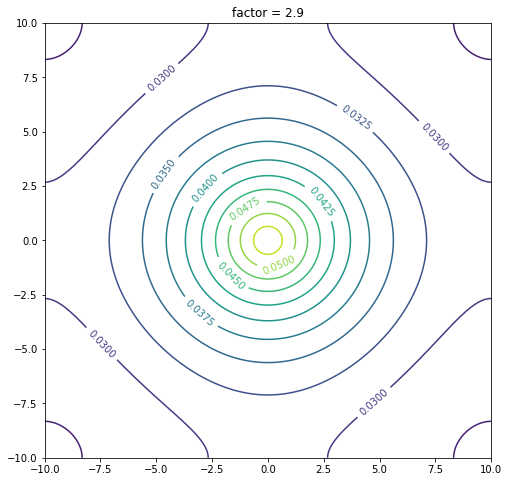

In [217]:

fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(xx,yy, Phi_plane/1e7,levels=10)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('factor = 2.9')
#CB = fig.colorbar(CS, shrink=0.8)
plt.show()

In [218]:
## use an exponential interpolations
interp = RegularGridInterpolator((xs, xs), np.log(Phi_plane))

In [219]:

thetas = np.linspace(0,np.pi/2,60)
points1 = 1.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points2 = 2.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points3 = 3.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points4 = 4.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points5 = 5.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points6 = 6.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points7 = 7.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points8 = 8.0*np.array([np.cos(thetas),np.sin(thetas)]).T


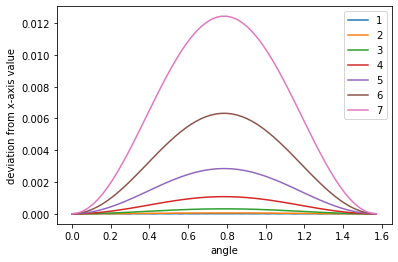

In [220]:
plt.plot(thetas,1-np.exp(interp(points1)-interp(points1)[0]),label='1')
plt.plot(thetas,1-np.exp(interp(points2)-interp(points2)[0]),label='2')
plt.plot(thetas,1-np.exp(interp(points3)-interp(points3)[0]),label='3')
plt.plot(thetas,1-np.exp(interp(points4)-interp(points4)[0]),label='4')
plt.plot(thetas,1-np.exp(interp(points5)-interp(points5)[0]),label='5')
plt.plot(thetas,1-np.exp(interp(points6)-interp(points6)[0]),label='6')
plt.plot(thetas,1-np.exp(interp(points7)-interp(points7)[0]),label='7')


plt.xlabel('angle')
plt.ylabel('deviation from x-axis value')
plt.legend()
plt.show()
#plt.plot(thetas,interp(points8)/interp(points8)[0])

### Bulge:

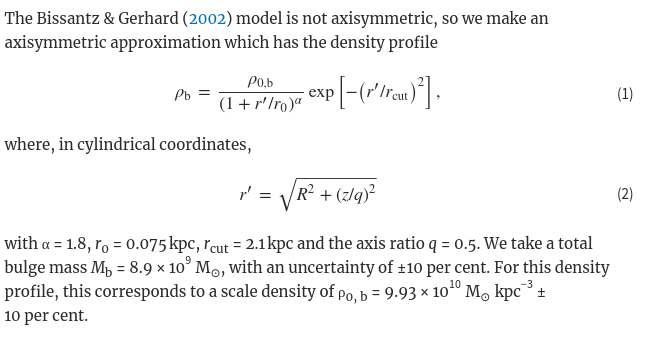

### Star Disks:

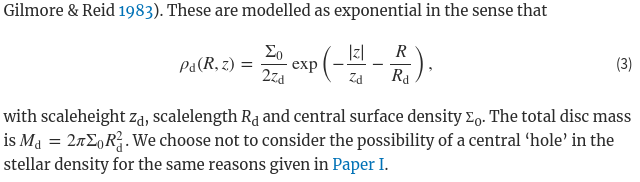


### Gas Disks:

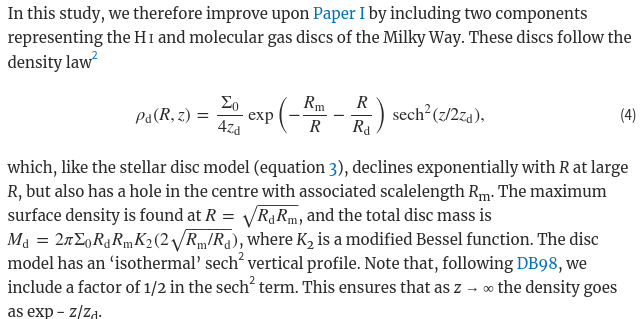

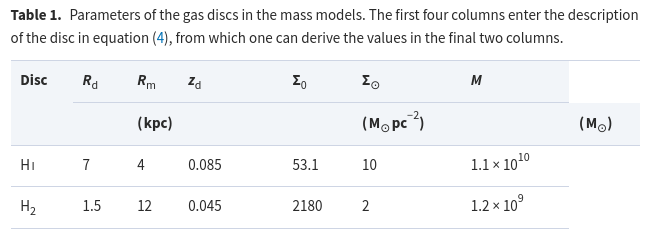

### Parameters:

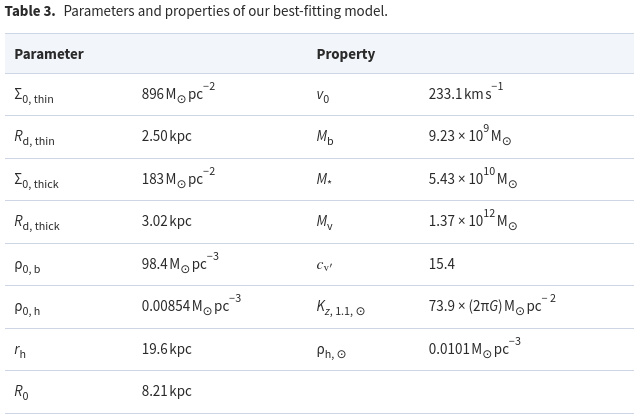


In [221]:
def chunked_prepare_gal(filename, props, slices=-1, debug=False, withdm=False):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    xs = props['xs']
    
    ## Bulge properties
    alpha = 1.8
    q     = 0.5
    r0_bulge = 0.075
    rcut_bulge = 2.10
    rho0_bulge = 9.93e10

    ## Thin and Thick star disks
    Rd_thin  = 2.5
    Rd_thick = 3.0
    Sigma0_thin  = 8.92e8
    Sigma0_thick = 1.83e8
    zd_thin = 0.3
    zd_thick = 0.9

    ## Gas disks
    Sigma0_HI = 5.3e7
    Sigma0_H2 = 2.18e9
    Rd_HI = 7.0
    Rd_H2 = 1.5
    Rm_HI = 4
    Rm_H2 = 12
    zd_HI = 0.085
    zd_H2 = 0.045
    
    ##DM Halo (NFW)
    rho0_dm = 8.54e6
    rh = 19.6
    gamma = 1
    
    if slices == -1:
        slices = props['slices']
    
    nn = NN//slices
    show_progress = not debug
    
    if debug:
        print("--------------------------------------------------",flush=True)
        print("Creating a galaxy density profile...\n",flush=True)
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex')
        
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            xsub = xs[ii*nn:(ii+1)*nn]
            xx,yy,zz = np.meshgrid(xsub,xs,xs,indexing='ij')
                        
            R      = np.sqrt(xx**2+yy**2)
            rprime = np.sqrt(R**2+(zz/q)**2)
            r      = np.sqrt(R**2+zz**2)
            
            density = 0.0j    + rho0_bulge*np.exp(-(rprime/rcut_bulge)**2)/np.power((1.0+rprime/r0_bulge),alpha)
            density = density + Sigma0_thin /(2.0*zd_thin )*np.exp(-np.abs(zz)/zd_thin  - R/Rd_thin )
            density = density + Sigma0_thick/(2.0*zd_thick)*np.exp(-np.abs(zz)/zd_thick - R/Rd_thick)            
            density = density + Sigma0_HI/(4.0*zd_HI)*np.exp( - Rm_HI/R - R/Rd_HI )/np.cosh(zz/(2.0*zd_HI))**2
            density = density + Sigma0_H2/(4.0*zd_H2)*np.exp( - Rm_H2/R - R/Rd_H2 )/np.cosh(zz/(2.0*zd_H2))**2
            if withdm:
                density = density + rho0_dm / (np.power(r,gamma)*np.power(1+r/rh,3-gamma))
            
            dset[ii*nn:(ii+1)*nn] = density/rho0
    
    if debug:
        sys.stderr.flush()
        #print("\ndone.",flush=True)
        print("\n--------------------------------------------------",flush=True)

In [222]:
props = generate_props(512,20.0)
chunked_prepare_gal('test_v1.h5',props,debug=True,withdm=True)

--------------------------------------------------
Creating a galaxy density profile...



100%|██████████| 2/2 [00:34<00:00, 17.36s/it]



--------------------------------------------------


In [223]:
extract_fiducial("test_v1.h5", "test_fid.h5", props)

100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


In [224]:
chunked_get_potential('test_v1.h5',props,2.9,debug=True)

--------------------------------------------------
Computing potential...



100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


In [225]:
extract_fiducial("test_v1.h5", "test_fid_pot.h5", props)

100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


In [226]:
fiducial_full = get_fullarray('test_fid.h5')

In [227]:
np.sum(fiducial_full)/1e9

67.107954688

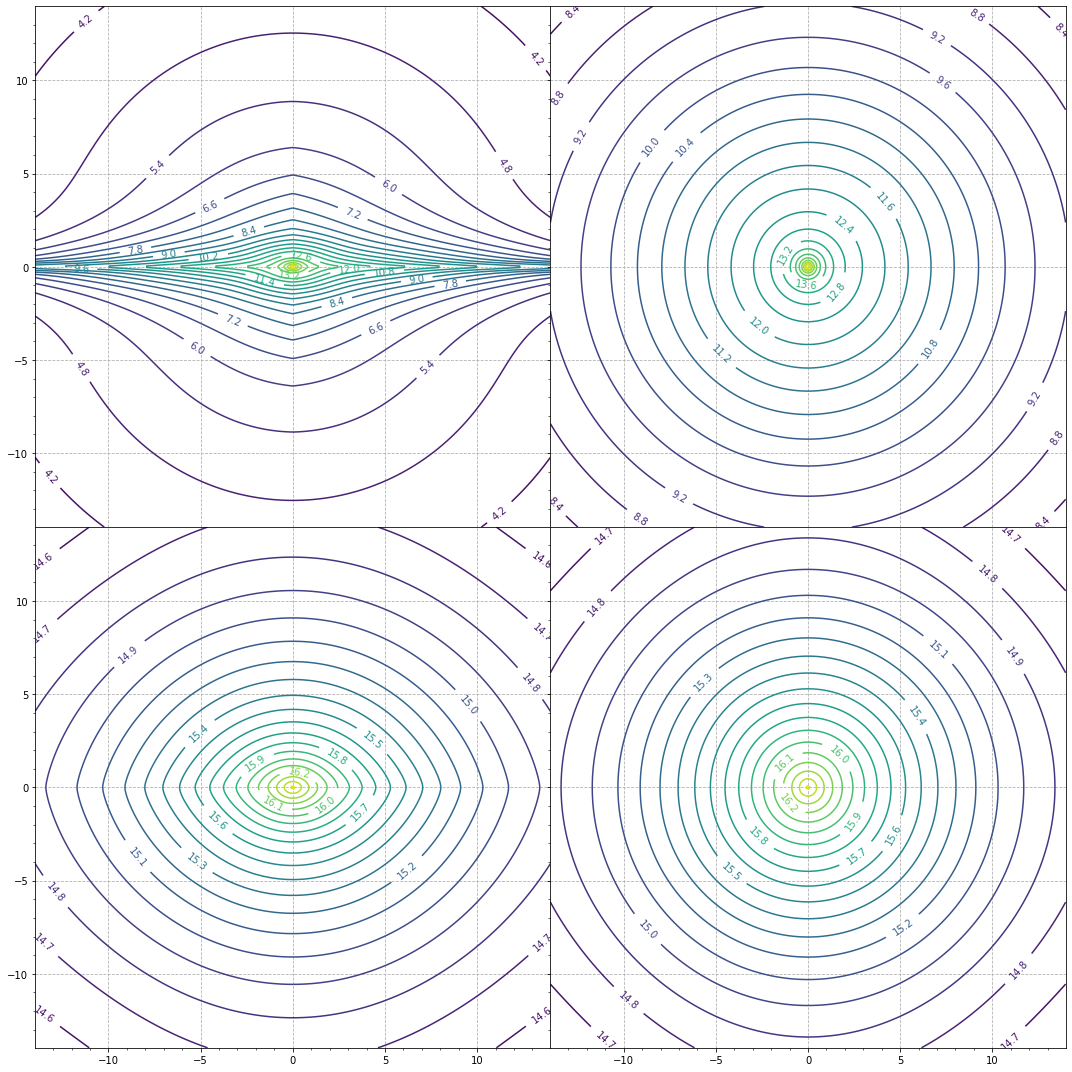

In [228]:
mid = props['mid']
fmid = props['fmid']
xs = props['xs']
fidx = props['fidx']

Rho_plane_yz = np.real(get_plane('test_fid.h5',props,index=fmid))
Rho_plane_xy = np.real(get_plane('test_fid.h5',props,index=fmid,axis=2))

Pot_plane_yz = np.real(get_plane('test_fid_pot.h5',props,index=fmid))
Pot_plane_xy = np.real(get_plane('test_fid_pot.h5',props,index=fmid,axis=2))

xx,yy = np.meshgrid(fidx,fidx)


fig, ax = plt.subplots(figsize=(15,15),nrows=2,ncols=2,sharex=True,sharey=True,gridspec_kw = {'wspace':0, 'hspace':0})

CS = ax[0,0].contour(xx,yy, np.log(Rho_plane_yz).T,levels=20)
ax[0,0].clabel(CS, inline=True, fontsize=10)
ax[0,0].grid(linestyle='--')

CS = ax[0,1].contour(xx,yy, np.log(Rho_plane_xy).T,levels=20)
ax[0,1].clabel(CS, inline=True, fontsize=10)
ax[0,1].grid(linestyle='--')

CS = ax[1,0].contour(xx,yy, np.log(Pot_plane_yz).T,levels=20)
ax[1,0].clabel(CS, inline=True, fontsize=10)
ax[1,0].grid(linestyle='--')

CS = ax[1,1].contour(xx,yy, np.log(Pot_plane_xy).T,levels=20)
ax[1,1].clabel(CS, inline=True, fontsize=10)
ax[1,1].grid(linestyle='--')


ax[0,0].minorticks_on()
plt.tight_layout()
plt.show()

In [229]:
## use an exponential interpolations
interp = RegularGridInterpolator((fidx, fidx), np.log(Pot_plane_xy))

interp_2 = RegularGridInterpolator((fidx, fidx), np.log(Pot_plane_yz))

In [230]:

thetas = np.linspace(0,np.pi,60)
points1  =  1.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points2  =  2.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points3  =  3.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points4  =  4.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points5  =  5.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points6  =  6.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points7  =  7.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points8  =  8.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points9  =  9.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points10 = 10.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points11 = 11.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points12 = 12.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points13 = 13.0*np.array([np.cos(thetas),np.sin(thetas)]).T


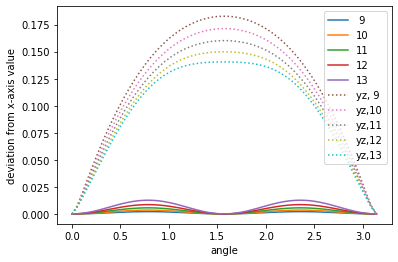

In [231]:
#plt.plot(thetas,1-np.exp(interp(points1)-interp(points1)[0]),label='1')
#plt.plot(thetas,1-np.exp(interp(points2)-interp(points2)[0]),label='2')
#plt.plot(thetas,1-np.exp(interp(points3)-interp(points3)[0]),label='3')
#plt.plot(thetas,1-np.exp(interp(points4)-interp(points4)[0]),label='4')
#plt.plot(thetas,1-np.exp(interp(points5)-interp(points5)[0]),label='5')
#plt.plot(thetas,1-np.exp(interp(points6)-interp(points6)[0]),label='6')
#plt.plot(thetas,1-np.exp(interp(points7)-interp(points7)[0]),label='7')
#plt.plot(thetas,1-np.exp(interp(points8)-interp(points8)[0]),label='8')
plt.plot(thetas,1-np.exp(interp(points9 )-interp(points9 )[0]),label=' 9')
plt.plot(thetas,1-np.exp(interp(points10)-interp(points10)[0]),label='10')
plt.plot(thetas,1-np.exp(interp(points11)-interp(points11)[0]),label='11')
plt.plot(thetas,1-np.exp(interp(points12)-interp(points12)[0]),label='12')
plt.plot(thetas,1-np.exp(interp(points13)-interp(points13)[0]),label='13')

plt.plot(thetas,1-np.exp(interp_2(points9 )-interp_2(points9 )[0]),':',label='yz, 9')
plt.plot(thetas,1-np.exp(interp_2(points10)-interp_2(points10)[0]),':',label='yz,10')
plt.plot(thetas,1-np.exp(interp_2(points11)-interp_2(points11)[0]),':',label='yz,11')
plt.plot(thetas,1-np.exp(interp_2(points12)-interp_2(points12)[0]),':',label='yz,12')
plt.plot(thetas,1-np.exp(interp_2(points13)-interp_2(points13)[0]),':',label='yz,13')



plt.xlabel('angle')
plt.ylabel('deviation from x-axis value')
plt.legend()
plt.show()
#plt.plot(thetas,interp(points8)/interp(points8)[0])